In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 参数设置
random_seed = 42
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)


class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()

        self.generator = nn.Sequential(

            nn.Linear(LATENT_DIM, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape1(),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            # nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            # nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            # nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            # nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            # nn.Dropout2d(p=0.2),

            Flatten(),

            nn.Linear(7 * 7 * 32, 1),
            # nn.Sigmoid()
        )

    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        pred = self.discriminator(img)
        return pred.view(-1)


torch.manual_seed(random_seed)


model = GAN()
model = model.to(device)
print(model)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

start_time = time.time()

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        # Normalize images to [-1, 1] range
        features = (features - 0.5) * 2.
        features = features.view(-1, IMG_SIZE).to(device)

        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)

        ### FORWARD AND BACK PROP

        # --------------------------
        # Train Generator
        # --------------------------

        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)

        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28))

        gener_loss = F.binary_cross_entropy_with_logits(discr_pred, valid)

        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()

        # --------------------------
        # Train Discriminator
        # --------------------------

        discr_pred_real = model.discriminator_forward(features.view(targets.size(0), 1, 28, 28))
        real_loss = F.binary_cross_entropy_with_logits(discr_pred_real, valid)

        discr_pred_fake = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake, fake)

        discr_loss = 0.5 * (real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()

        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())

        ### LOGGING
        if not batch_idx % 100:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx,
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))


%matplotlib inline
import matplotlib.pyplot as plt

ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
plt.show()



model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')
    
    from torchsummary import summary

model = model.to(device)
summary(model.generator, input_size=(100,))
summary(model.discriminator, input_size=(1, 28, 28))


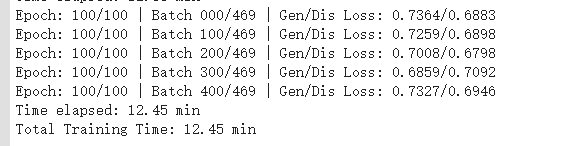

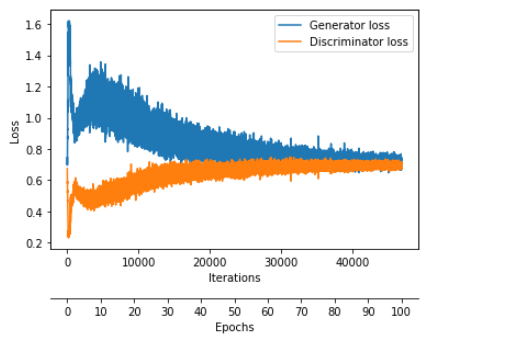

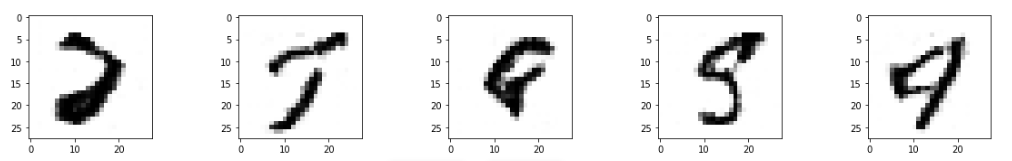

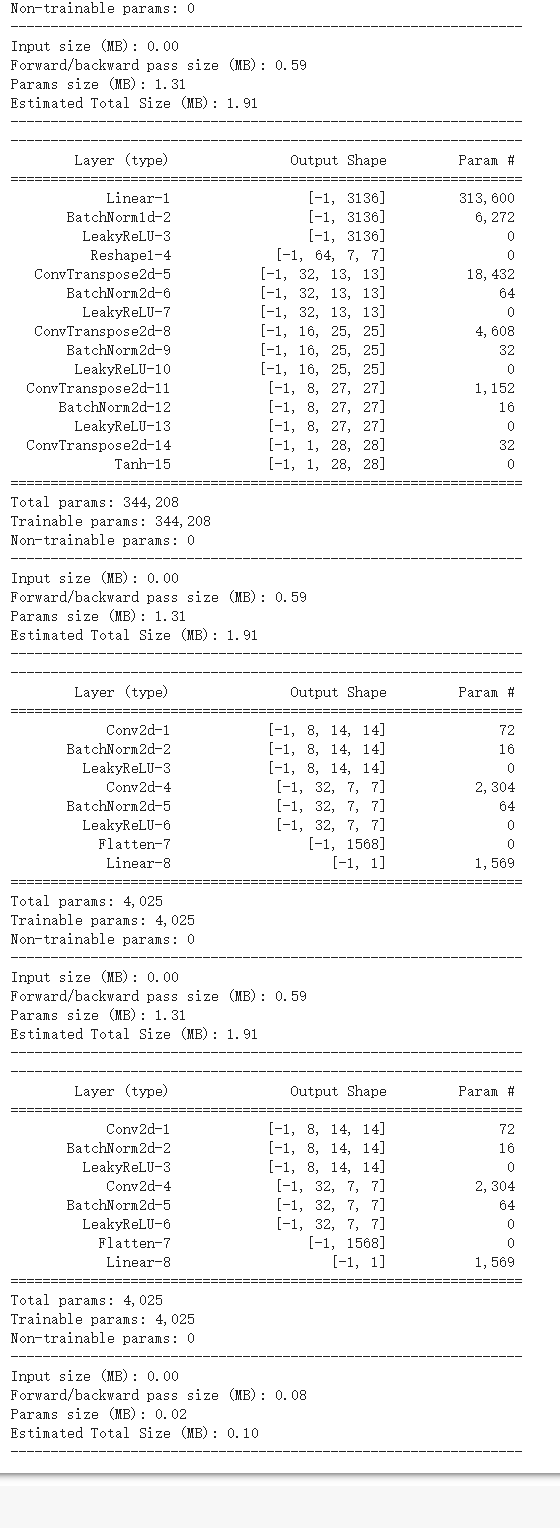